In [147]:
import pandas as pd 
import numpy as np

In [148]:
df = pd.read_csv('DataSet/titles.csv')

In [149]:
df = df.drop(["description","seasons","imdb_id","age_certification"],axis=1)

In [150]:
import seaborn as sns

In [151]:
import pandas as pd
from sklearn.impute import KNNImputer

# Select float columns
float_cols = df.select_dtypes(include=['float64']).columns

# Create imputer and apply only to float columns
imputer = KNNImputer(n_neighbors=5)  # Adjust n_neighbors as needed
df[float_cols] = imputer.fit_transform(df[float_cols])


In [152]:
df2 = pd.read_csv('DataSet\credits.csv')

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\HARSH\AppData\Local\Temp\ipykernel_15088\3480963247.py:1: SyntaxWarning: invalid escape sequence '\c'
  df2 = pd.read_csv('DataSet\credits.csv')


In [153]:
df2=df2.drop(columns=['person_id','character'],axis=1)
df2.columns

Index(['id', 'name', 'role'], dtype='object')

In [154]:
grouped = df2.groupby(['id', 'role'])['name'].agg(set).reset_index()

result = grouped.pivot_table(index='id', columns='role', values='name', aggfunc=lambda x: x, fill_value='').reset_index()

# Rename the columns
result.columns = ['id', 'cast', 'director']
df2=result

In [155]:
merged_df = pd.merge(df, df2, on="id", suffixes=("_df1", "_df2"))

In [156]:
merged_df.dropna(inplace=True)
merged_df.isnull().sum()
merged_df['director'] = merged_df['director'].astype(str)
merged_df['cast'] = merged_df['cast'].astype(str)

In [157]:
cols=['id','type','release_year','runtime','genres','production_countries','imdb_score','imdb_votes','cast','director']
tdf=pd.DataFrame()
for col in cols:
    tdf[col]=merged_df[col]

In [158]:
# Define a function to remove punctuation
def remove_punctuation(text):
  import string
  return ''.join([c for c in text if c not in string.punctuation])

# Apply the function to the entire feature column
tdf['genres'] = tdf['genres'].apply(remove_punctuation)
tdf['production_countries'] = tdf['production_countries'].apply(remove_punctuation)
tdf['cast'] = tdf['cast'].apply(remove_punctuation)
tdf['director'] = tdf['director'].apply(remove_punctuation)
tdf['type'] = tdf['type'].apply(remove_punctuation)


In [159]:
def split_genres(text):
  return set(text.lower().split())

# Apply the function to the entire feature column
tdf['genres'] = tdf['genres'].apply(split_genres)
tdf['cast'] = tdf['cast'].apply(split_genres)
tdf['director'] = tdf['director'].apply(split_genres)
tdf['production_countries'] = tdf['production_countries'].apply(split_genres)
tdf['type'] = tdf['type'].apply(split_genres)

In [160]:
from sklearn.preprocessing import MultiLabelBinarizer
mlbg = MultiLabelBinarizer()
mlbc = MultiLabelBinarizer()
mlbt = MultiLabelBinarizer()
mlbg.fit(tdf["genres"])
mlbc.fit(tdf['production_countries'])
mlbt.fit(tdf['type'])
encoded_genres = mlbg.transform(tdf["genres"])
encoded_countries = mlbc.transform(tdf['production_countries'])
encoded_type = mlbt.transform(tdf['type'])

In [161]:
def convert(arr):
    num=0
    for i in range(arr.size):
        num = num+arr[i]*(2**i)
    return num

In [162]:
def full(encoded_arr):
    arr = []
    for i in range(5488):
        arr.append(convert(encoded_arr[i]))
    return arr
encoded_genres=full(encoded_genres)
encoded_countries=full(encoded_countries)
encoded_type=full(encoded_type)

In [163]:
tdf.columns

Index(['id', 'type', 'release_year', 'runtime', 'genres',
       'production_countries', 'imdb_score', 'imdb_votes', 'cast', 'director'],
      dtype='object')

In [164]:
fdf = pd.DataFrame()
cols=['release_year', 'runtime',
       'imdb_score', 'imdb_votes']
for col in cols:
    fdf[col]=tdf[col]
fdf['genres']=encoded_genres
fdf['production_countries']=encoded_countries
# fdf['type']=encoded_type
fdf

,release_year,runtime,imdb_score,imdb_votes,genres,production_countries
0,1976,114,8.20,808582.0,40,1.267651e+30
1,1972,109,7.70,107673.0,65633,1.267651e+30
2,1975,91,8.20,534486.0,261,4.294967e+09
3,1967,150,7.70,72662.0,131073,1.267651e+30
4,1969,30,8.80,73424.0,68,4.294967e+09
...,...,...,...,...,...,...
5484,2022,26,6.26,84.2,0,0.000000e+00
5485,2021,115,7.10,50.0,8196,1.511157e+23
5486,2021,93,5.00,327.0,8228,1.342177e+08
5487,2021,100,6.80,45.0,8224,2.361183e+21


In [165]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, init='k-means++', random_state=42, n_init=10)  # Use k-means++ for better initialization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(fdf)
kmeans.fit(scaled_features)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Get the coordinates of the cluster centers
centers = kmeans.cluster_centers_

In [166]:
labels.size

5488

In [167]:
unique, counts = np.unique(labels, return_counts=True)

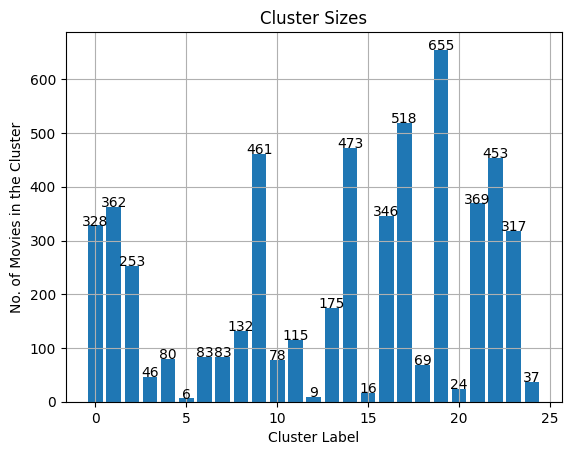

In [168]:
import matplotlib.pyplot as plt
plt.bar(unique,counts)  # Basic histogram
for i, v in enumerate(counts):
    plt.text(i, v + 0.2, str(v), ha='center')  # Adjust vertical offset as needed
# Customize appearance (optional):
plt.xlabel("Cluster Label")
plt.ylabel("No. of Movies in the Cluster")
plt.title("Cluster Sizes")
plt.grid(True)  # Add grid lines

In [169]:
import pickle
with open('cluster.pickle','wb') as f: #Creating and opening a file named linearregression.pickle
    pickle.dump(kmeans, f)#Dumping clf into file f

In [170]:
with open('my_dataframe.pkl', 'wb') as f:
    pickle.dump(merged_df, f)